<a href="https://colab.research.google.com/github/i-Ash/Poison-ML-model/blob/main/Poison_ML_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
#Load the dataset
file_path = "/content/Heart Attack.csv"
data = pd.read_csv(file_path)

In [5]:
data.head()


,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative



Accuracy Results (Before and After Poisoning):

SVM:
  Accuracy after 0% poisoning: 0.69
  Accuracy after 5% poisoning: 0.68
  Accuracy after 10% poisoning: 0.67
  Accuracy after 20% poisoning: 0.64

Logistic Regression:
  Accuracy after 0% poisoning: 0.78
  Accuracy after 5% poisoning: 0.76
  Accuracy after 10% poisoning: 0.73
  Accuracy after 20% poisoning: 0.70

Random Forest:
  Accuracy after 0% poisoning: 0.99
  Accuracy after 5% poisoning: 0.98
  Accuracy after 10% poisoning: 0.98
  Accuracy after 20% poisoning: 0.98

Decision Tree:
  Accuracy after 0% poisoning: 0.99
  Accuracy after 5% poisoning: 0.93
  Accuracy after 10% poisoning: 0.87
  Accuracy after 20% poisoning: 0.78


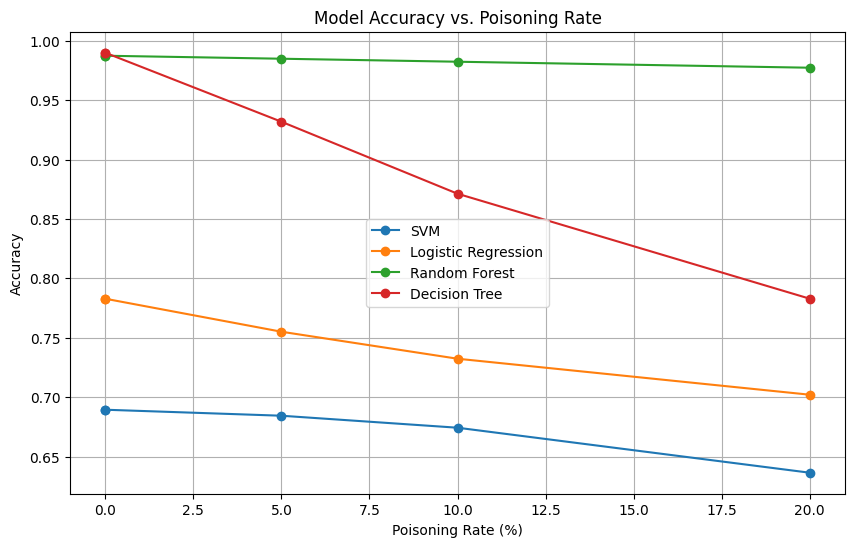

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set a random seed for reproducibility
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

# Separate features and target
target_column = "class"
X = data.drop(columns=[target_column])
y = data[target_column]

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Encode target labels (i.e., "positive" -> 1, "negative" -> 0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

# Poisoning rates
poison_rates = [0, 5, 10, 20]

# Models with fixed random states
models = {
    "SVM": SVC(random_state=RANDOM_SEED),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_SEED),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_SEED),
}

# Store results
results = {model_name: {"clean": None, "poisoned": {rate: None for rate in poison_rates}} for model_name in models}

# Evaluate models on clean data (0% poisoning)
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[model_name]["clean"] = accuracy_score(y_test, y_pred)

# Evaluate models on poisoned data
for rate in poison_rates:
    num_poisoned = int((rate / 100) * len(y_train))
    poisoned_y_train = y_train.copy()
    if num_poisoned > 0:
        poison_indices = np.random.choice(len(y_train), num_poisoned, replace=False)
        for idx in poison_indices:
            original_label = poisoned_y_train[idx]
            other_labels = [label for label in np.unique(y) if label != original_label]
            poisoned_y_train[idx] = np.random.choice(other_labels)

    # Train and evaluate each model on poisoned data
    for model_name, model in models.items():
        model.fit(X_train, poisoned_y_train)
        y_pred = model.predict(X_test)
        results[model_name]["poisoned"][rate] = accuracy_score(y_test, y_pred)

# Display results
print("\nAccuracy Results (Before and After Poisoning):")
for model_name, model_results in results.items():
    print(f"\n{model_name}:")
    for rate, acc in model_results["poisoned"].items():
        print(f"  Accuracy after {rate}% poisoning: {acc:.2f}")

# Plot results
plt.figure(figsize=(10, 6))
for model_name, model_results in results.items():
    accuracies = [model_results["clean"]] + [model_results["poisoned"][rate] for rate in poison_rates]
    plt.plot([0] + poison_rates, accuracies, marker='o', label=model_name)

plt.title("Model Accuracy vs. Poisoning Rate")
plt.xlabel("Poisoning Rate (%)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()